In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from gensim.models import LdaMulticore, TfidfModel, CoherenceModel
from gensim.utils import simple_preprocess
from gensim.models.phrases import Phrases
from gensim.corpora import Dictionary
from nltk.corpus import stopwords
import pyLDAvis.gensim_models, pyLDAvis, multiprocessing, gensim, spacy
import warnings, logging, seaborn, shutil, pickle, pprint, time, os, re
import gensim.corpora as corpora
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

%matplotlib inline

# Latent Dirichlet Allocation: Feature Engineering
#### We use our LDA model to generate features for each player depending on the topics

In [32]:
pd.set_option('display.max_colwidth', 1000)

# Import our reports
path = 'dataset-quarterback_scouting_reports'
filename = 'qb_draft_reports.csv'
df = pd.read_csv(os.path.join(path, filename))
df.head(3)

,Player,Year,School,Source,Report
0,Zach Wilson,2021,BYU,NFL,Wilson was the runner-up for Utah's Mr Football Award in 2017 after throwing for nearly 3 000 yards and 24 touchdowns at Corner Canyon High School His father Mike played defensive tackle at Utah under current Utes head coach Kyle Whittingham (who was then the D-line coach) but they already had a quarterback recruited for the 2018 class So Wilson signed with arch-rival BYU and started seven of nine games played as a true freshman (120-of-182 65 9% completion rate 1 578 yards 12 TDs three INTs passing; 75-211-2 9 two TDs rushing) finishing the season with a Famous Idaho Potato Bowl MVP effort (18-of-18 317 yards four TDs) He underwent right (throwing) shoulder surgery after the season for an injury he suffered in high school He started nine games (199-of-319 62 4% 2 382 yards 11 TDs 9 INTs passing; 67-167-2 5 3 TDs rushing) in 2019 but missed time with a fractured right thumb that required surgery Wilson broke out in 2020 sharing the Polynesian Player of the ...
1,Zach Wilson,2021,BYU,ESPN,Wilson is a lean quarterback with good mobility and arm strength He played in a pistol-heavy offense at BYU that featured full-field reads (mostly pro-style concepts) One of his best traits is his ability to extend plays He has the instincts and agility to create after the initial play breaks down and he also does a very good job of adjusting his arm angles to generate throwing windows His ability to throw receivers open also stands out as Wilson shows above-average touch against zone looks He doesnt appear to have great top-end speed but hes an instinctive runner with good quickness and competitiveness Wilson is a premier quarterback prospect with all the mental and physical tools to excel as a NFL starter so long as his undersized frame holds up <em>-- Final evaluation</em>
2,Zach Wilson,2021,BYU,WalterFootball,Powerful right arm Can make all the throws in the NFL Pushes the ball downfield Accurate passer Can throw a hard fastball into tight windows Good deep-ball accuracy Throws a pretty deep ball Makes big throws off platform Able to loft in touch passes Throws a catchable ball Stands tall in the pocket Moves his eyes Works through his progression Can throw receivers open Doesn't miss open receivers Shows good timing Anticipation Good athlete Dangerous runner Can buy time with his feet Can hurt defenses on the ground Quickness and burst as a runner Quick feet Shifty runner in the open field Wise to avoid hits as a senior Intelligent Good recall Confident Competitor Brings energy to his team Upside Aspects of poor football character One-year wonder Lean build could stand to add weight Lacks experience against elite competition Should get quicker working through progressions Accuracy suffers under pressure Entering his senior year I wrote that Wilson ...


In [33]:
path = 'dataset-quarterback_stats'
filename = 'census.csv'

# Import info about players ethnicity
df2 = pd.read_csv(os.path.join(path, filename))

# Merge df and df2
df = df.merge(df2, how='left', on='Player')
df = df[['Player', 'Year', 'Race', 'School', 'Source', 'Report']]
df.head(3)

,Player,Year,Race,School,Source,Report
0,Zach Wilson,2021,White,BYU,NFL,Wilson was the runner-up for Utah's Mr Football Award in 2017 after throwing for nearly 3 000 yards and 24 touchdowns at Corner Canyon High School His father Mike played defensive tackle at Utah under current Utes head coach Kyle Whittingham (who was then the D-line coach) but they already had a quarterback recruited for the 2018 class So Wilson signed with arch-rival BYU and started seven of nine games played as a true freshman (120-of-182 65 9% completion rate 1 578 yards 12 TDs three INTs passing; 75-211-2 9 two TDs rushing) finishing the season with a Famous Idaho Potato Bowl MVP effort (18-of-18 317 yards four TDs) He underwent right (throwing) shoulder surgery after the season for an injury he suffered in high school He started nine games (199-of-319 62 4% 2 382 yards 11 TDs 9 INTs passing; 67-167-2 5 3 TDs rushing) in 2019 but missed time with a fractured right thumb that required surgery Wilson broke out in 2020 sharing the Polynesian Player of the ...
1,Zach Wilson,2021,White,BYU,ESPN,Wilson is a lean quarterback with good mobility and arm strength He played in a pistol-heavy offense at BYU that featured full-field reads (mostly pro-style concepts) One of his best traits is his ability to extend plays He has the instincts and agility to create after the initial play breaks down and he also does a very good job of adjusting his arm angles to generate throwing windows His ability to throw receivers open also stands out as Wilson shows above-average touch against zone looks He doesnt appear to have great top-end speed but hes an instinctive runner with good quickness and competitiveness Wilson is a premier quarterback prospect with all the mental and physical tools to excel as a NFL starter so long as his undersized frame holds up <em>-- Final evaluation</em>
2,Zach Wilson,2021,White,BYU,WalterFootball,Powerful right arm Can make all the throws in the NFL Pushes the ball downfield Accurate passer Can throw a hard fastball into tight windows Good deep-ball accuracy Throws a pretty deep ball Makes big throws off platform Able to loft in touch passes Throws a catchable ball Stands tall in the pocket Moves his eyes Works through his progression Can throw receivers open Doesn't miss open receivers Shows good timing Anticipation Good athlete Dangerous runner Can buy time with his feet Can hurt defenses on the ground Quickness and burst as a runner Quick feet Shifty runner in the open field Wise to avoid hits as a senior Intelligent Good recall Confident Competitor Brings energy to his team Upside Aspects of poor football character One-year wonder Lean build could stand to add weight Lacks experience against elite competition Should get quicker working through progressions Accuracy suffers under pressure Entering his senior year I wrote that Wilson ...


In [34]:
### LOAD CHECKPOINT
checkpoint = '__checkpoints'
path = 'lda_model_overall'
filename_lda = 'lda_model_overall'
filename_corpus = 'corpus_overall'
filename_data = 'data_overall'
filename_datawords = 'data_words_overall'
filename_dataready = 'data_ready_overall'

# Let's load a checkpoint of our model and corpus
lda_model =  gensim.models.LdaModel.load(os.path.join(checkpoint, path, filename_lda))

with open(os.path.join(checkpoint, filename_corpus + '.pkl'), 'rb') as f:
    corpus = pickle.load(f)

with open(os.path.join(checkpoint, path, filename_data + '.pkl'), 'rb') as f:
    data = pickle.load(f)

with open(os.path.join(checkpoint, path, filename_datawords + '.pkl'), 'rb') as f:
    data_words = pickle.load(f)

with open(os.path.join(checkpoint, path, filename_dataready + '.pkl'), 'rb') as f:
    data_ready = pickle.load(f)

In [35]:
# Add new columns to store the features obtained from the topics
df.insert(5, 'Topic_1',  np.nan)
df.insert(6, 'Topic_2',  np.nan)
df.insert(7, 'Topic_3',  np.nan)
df.insert(8, 'Topic_4',  np.nan)
df.insert(9, 'Topic_5',  np.nan)
df.head(3)

,Player,Year,Race,School,Source,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Report
0,Zach Wilson,2021,White,BYU,NFL,NaN,NaN,NaN,NaN,NaN,Wilson was the runner-up for Utah's Mr Football Award in 2017 after throwing for nearly 3 000 yards and 24 touchdowns at Corner Canyon High School His father Mike played defensive tackle at Utah under current Utes head coach Kyle Whittingham (who was then the D-line coach) but they already had a quarterback recruited for the 2018 class So Wilson signed with arch-rival BYU and started seven of nine games played as a true freshman (120-of-182 65 9% completion rate 1 578 yards 12 TDs three INTs passing; 75-211-2 9 two TDs rushing) finishing the season with a Famous Idaho Potato Bowl MVP effort (18-of-18 317 yards four TDs) He underwent right (throwing) shoulder surgery after the season for an injury he suffered in high school He started nine games (199-of-319 62 4% 2 382 yards 11 TDs 9 INTs passing; 67-167-2 5 3 TDs rushing) in 2019 but missed time with a fractured right thumb that required surgery Wilson broke out in 2020 sharing the Polynesian Player of the ...
1,Zach Wilson,2021,White,BYU,ESPN,NaN,NaN,NaN,NaN,NaN,Wilson is a lean quarterback with good mobility and arm strength He played in a pistol-heavy offense at BYU that featured full-field reads (mostly pro-style concepts) One of his best traits is his ability to extend plays He has the instincts and agility to create after the initial play breaks down and he also does a very good job of adjusting his arm angles to generate throwing windows His ability to throw receivers open also stands out as Wilson shows above-average touch against zone looks He doesnt appear to have great top-end speed but hes an instinctive runner with good quickness and competitiveness Wilson is a premier quarterback prospect with all the mental and physical tools to excel as a NFL starter so long as his undersized frame holds up <em>-- Final evaluation</em>
2,Zach Wilson,2021,White,BYU,WalterFootball,NaN,NaN,NaN,NaN,NaN,Powerful right arm Can make all the throws in the NFL Pushes the ball downfield Accurate passer Can throw a hard fastball into tight windows Good deep-ball accuracy Throws a pretty deep ball Makes big throws off platform Able to loft in touch passes Throws a catchable ball Stands tall in the pocket Moves his eyes Works through his progression Can throw receivers open Doesn't miss open receivers Shows good timing Anticipation Good athlete Dangerous runner Can buy time with his feet Can hurt defenses on the ground Quickness and burst as a runner Quick feet Shifty runner in the open field Wise to avoid hits as a senior Intelligent Good recall Confident Competitor Brings energy to his team Upside Aspects of poor football character One-year wonder Lean build could stand to add weight Lacks experience against elite competition Should get quicker working through progressions Accuracy suffers under pressure Entering his senior year I wrote that Wilson ...


In [36]:
for index, row in df.iterrows():
    topics = lda_model.get_document_topics(corpus[index], minimum_probability=0.0)
    df.at[index, 'Topic_1'] = topics[0][1]
    df.at[index, 'Topic_2'] = topics[1][1]
    df.at[index, 'Topic_3'] = topics[2][1]
    df.at[index, 'Topic_4'] = topics[3][1]
    df.at[index, 'Topic_5'] = topics[4][1]

df.head(5)

,Player,Year,Race,School,Source,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Report
0,Zach Wilson,2021,White,BYU,NFL,0.381061,0.236944,0.135174,0.000736,0.246084,Wilson was the runner-up for Utah's Mr Football Award in 2017 after throwing for nearly 3 000 yards and 24 touchdowns at Corner Canyon High School His father Mike played defensive tackle at Utah under current Utes head coach Kyle Whittingham (who was then the D-line coach) but they already had a quarterback recruited for the 2018 class So Wilson signed with arch-rival BYU and started seven of nine games played as a true freshman (120-of-182 65 9% completion rate 1 578 yards 12 TDs three INTs passing; 75-211-2 9 two TDs rushing) finishing the season with a Famous Idaho Potato Bowl MVP effort (18-of-18 317 yards four TDs) He underwent right (throwing) shoulder surgery after the season for an injury he suffered in high school He started nine games (199-of-319 62 4% 2 382 yards 11 TDs 9 INTs passing; 67-167-2 5 3 TDs rushing) in 2019 but missed time with a fractured right thumb that required surgery Wilson broke out in 2020 sharing the Polynesian Player of the ...
1,Zach Wilson,2021,White,BYU,ESPN,0.048303,0.034207,0.003432,0.003457,0.910600,Wilson is a lean quarterback with good mobility and arm strength He played in a pistol-heavy offense at BYU that featured full-field reads (mostly pro-style concepts) One of his best traits is his ability to extend plays He has the instincts and agility to create after the initial play breaks down and he also does a very good job of adjusting his arm angles to generate throwing windows His ability to throw receivers open also stands out as Wilson shows above-average touch against zone looks He doesnt appear to have great top-end speed but hes an instinctive runner with good quickness and competitiveness Wilson is a premier quarterback prospect with all the mental and physical tools to excel as a NFL starter so long as his undersized frame holds up <em>-- Final evaluation</em>
2,Zach Wilson,2021,White,BYU,WalterFootball,0.040671,0.310405,0.030380,0.229075,0.389470,Powerful right arm Can make all the throws in the NFL Pushes the ball downfield Accurate passer Can throw a hard fastball into tight windows Good deep-ball accuracy Throws a pretty deep ball Makes big throws off platform Able to loft in touch passes Throws a catchable ball Stands tall in the pocket Moves his eyes Works through his progression Can throw receivers open Doesn't miss open receivers Shows good timing Anticipation Good athlete Dangerous runner Can buy time with his feet Can hurt defenses on the ground Quickness and burst as a runner Quick feet Shifty runner in the open field Wise to avoid hits as a senior Intelligent Good recall Confident Competitor Brings energy to his team Upside Aspects of poor football character One-year wonder Lean build could stand to add weight Lacks experience against elite competition Should get quicker working through progressions Accuracy suffers under pressure Entering his senior year I wrote that Wilson ...
3,Zach Wilson,2021,White,BYU,Gamehaus,0.107132,0.479906,0.101288,0.000980,0.310693,Wilson rose up draft boards this season more than any other player After his terrific junior season Wilson has elected to declare for the 2021 NFL Draft </p>He was a three-star prospect who had offers from a lot of schools but chose to go to BYU for his college career In his freshman season Wilson played in nine games finishing with 1 578 passing yards 12 touchdowns and three interceptions on 65 9 percent completion The Cougars went 7-6 that season and finished the year with a win in the Famous Idaho Potato Bowl As a sophomore Wilson played in nine games again with 2 382 passing yards 11 touchdowns and nine interceptions on 62 4 percent completion BYU won seven games again during Wilson’s sophomore season Wilson broke out as a junior as he passed for 3 692 yards 33 touchdowns and three interceptions on 73 5 percent completion The Cougars won all but one ga

In [37]:
# Save our dataset
path = 'dataset-quarterback_scouting_reports'
filename = 'qb_draft_reports_topics.csv'

df.to_csv(os.path.join(path, filename), index=False)

In [3]:
# Load our dataset
path = 'dataset-quarterback_scouting_reports'
filename = 'qb_draft_reports_topics.csv'

df = pd.read_csv(os.path.join(path, filename))
df.head(3)

,Player,Year,Race,School,Source,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Report
0,Zach Wilson,2021,White,BYU,NFL,0.381061,0.236944,0.135174,0.000736,0.246084,Wilson was the runner-up for Utah's Mr Footb...
1,Zach Wilson,2021,White,BYU,ESPN,0.048303,0.034207,0.003432,0.003457,0.910600,Wilson is a lean quarterback with good mobili...
2,Zach Wilson,2021,White,BYU,WalterFootball,0.040671,0.310405,0.030380,0.229075,0.389470,Powerful right arm Can make all the throws i...


In [5]:
df0 = df[['Race', 'Topic_1', 'Topic_2', 'Topic_3', 'Topic_4', 'Topic_5']].mean(numeric_only=True)
df1 = pd.DataFrame([[df0[i] for i in range(5)]], columns=['Topic_1', 'Topic_2', 'Topic_3', 'Topic_4', 'Topic_5'])
df1

,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5
0,0.147745,0.253529,0.147594,0.052781,0.398352


In [6]:
df2 = df[['Race', 'Topic_1', 'Topic_2', 'Topic_3', 'Topic_4', 'Topic_5']].groupby('Race').mean().reset_index()
df2

,Race,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5
0,Non-White,0.146783,0.257125,0.144684,0.058034,0.393374
1,White,0.148142,0.252043,0.148796,0.050609,0.400409


In [10]:
df2[df2['Race'] == 'White'][[x]].loc[0]

,Race,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5
1,White,0.148142,0.252043,0.148796,0.050609,0.400409


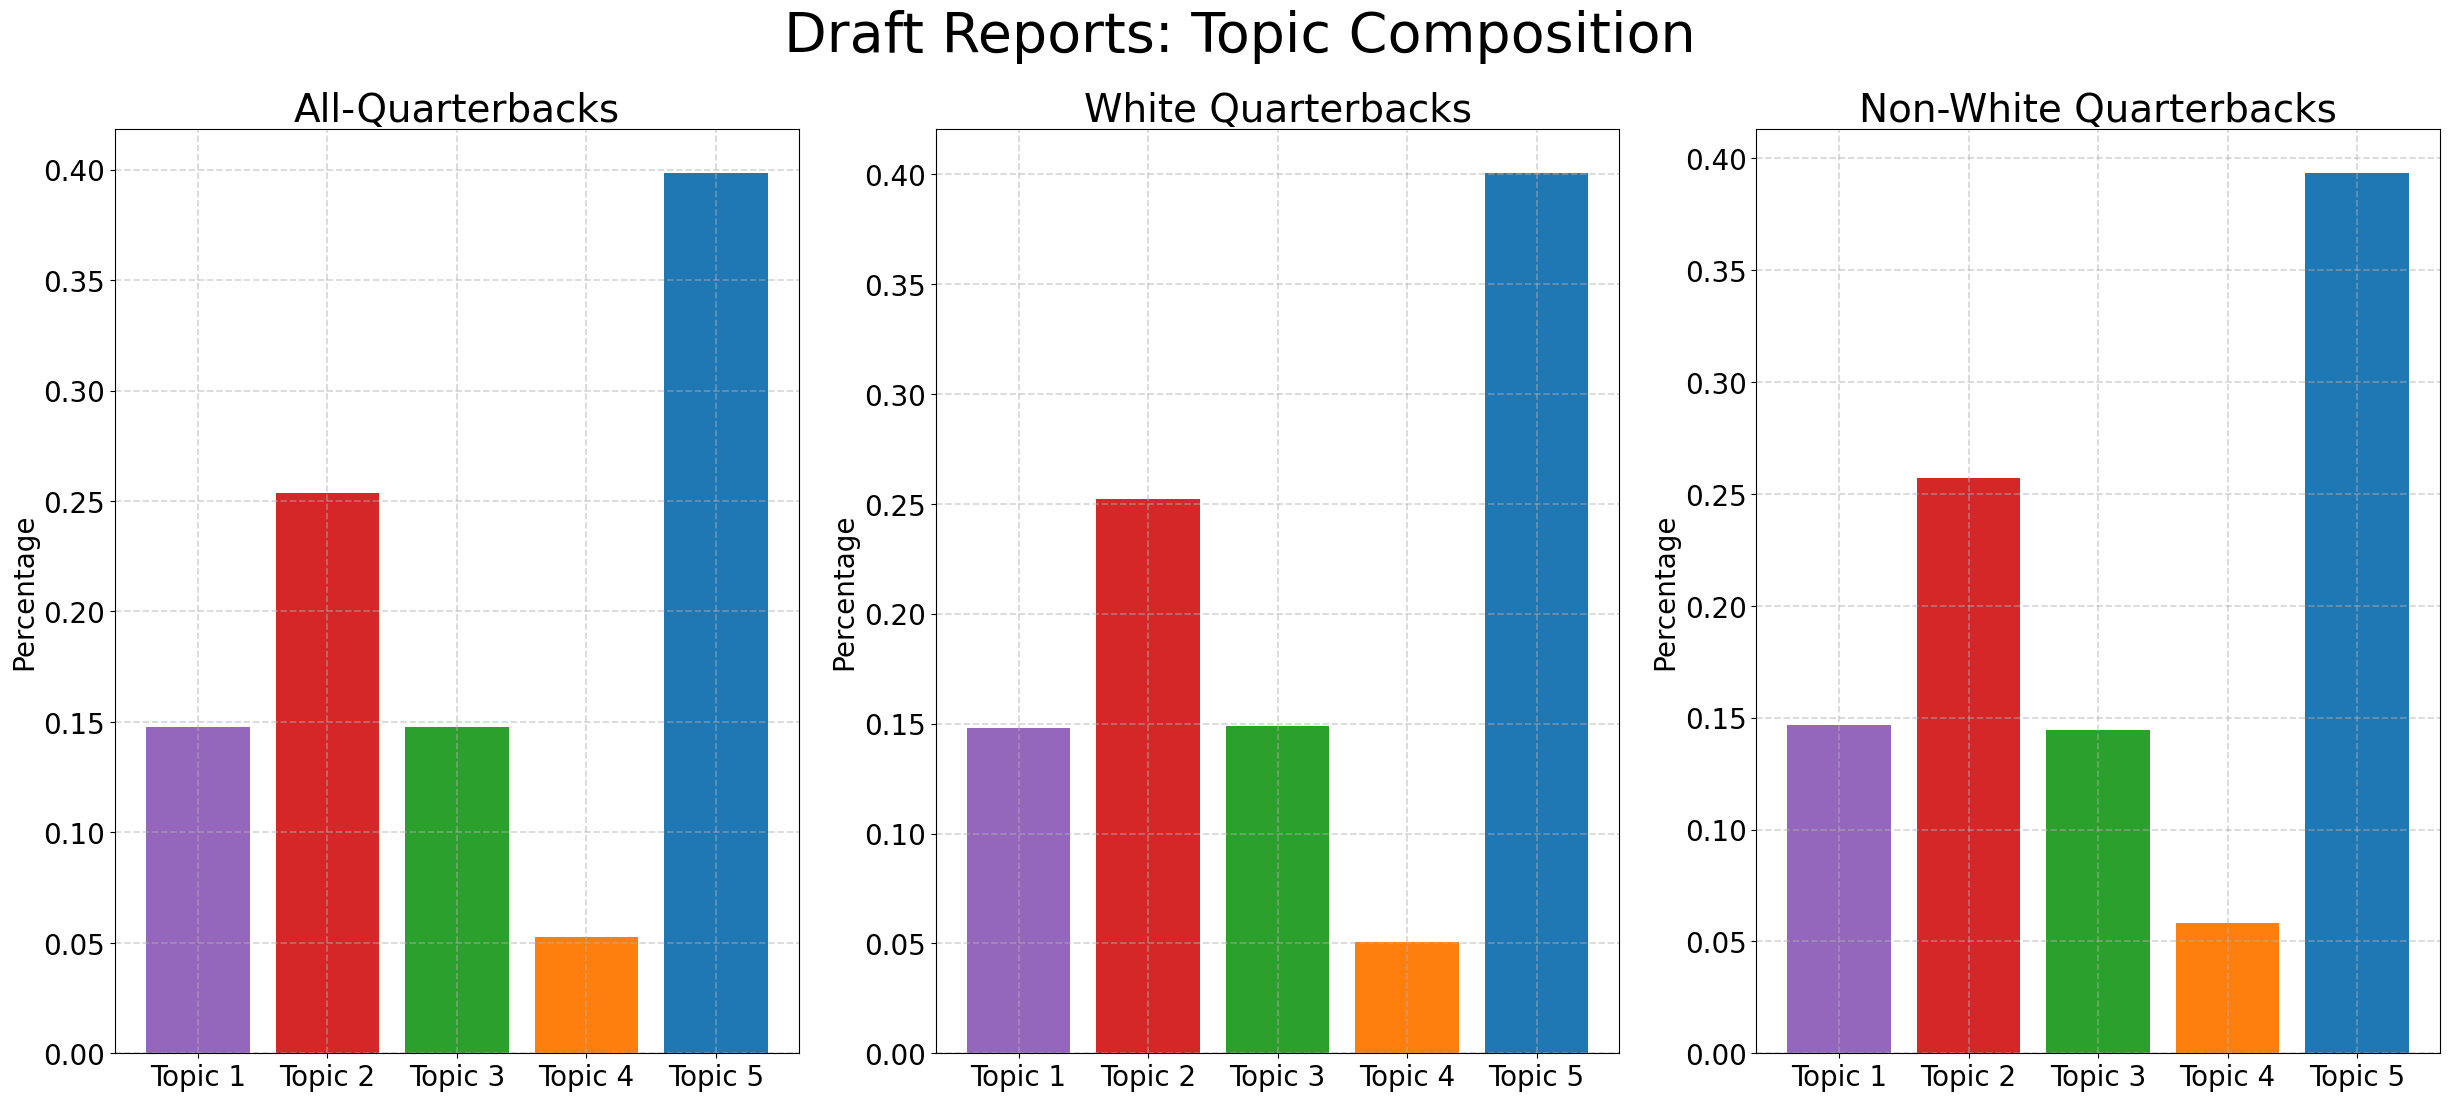

In [47]:
fig, axs = plt.subplots(1, 3, figsize=(30, 12))
plt.rcParams.update({'font.size': 20})

cols = ['Topic_1', 'Topic_2', 'Topic_3', 'Topic_4', 'Topic_5']
x = ['Topic 1', 'Topic 2', 'Topic 3', 'Topic 4', 'Topic 5']
colors = ['tab:purple', 'tab:red', 'tab:green',  'tab:orange', 'tab:blue']
yticks = np.arange(0, 0.41, 0.05)
grid_alpha = 0.5
linestyle = '--'
linewidth = 1.25

ax = axs[0]
y = df1.loc[0]
ax.bar(x, y, color=colors)
ax.set(ylabel='Percentage', yticks=yticks)
ax.set_title('All-Quarterbacks', fontsize=28)
ax.grid(alpha=grid_alpha, linestyle=linestyle, linewidth=linewidth)

ax = axs[1]
y = df2[df2['Race'] == 'White'][cols].reset_index(drop=True).loc[0]
ax.bar(x, y, color=colors)
ax.set(ylabel='Percentage', yticks=yticks)
ax.set_title('White Quarterbacks', fontsize=28)
ax.grid(alpha=grid_alpha, linestyle=linestyle, linewidth=linewidth)

ax = axs[2]
y = df2[df2['Race'] == 'Non-White'][cols].reset_index(drop=True).loc[0]
ax.bar(x, y, color=colors)
ax.set(ylabel='Percentage', yticks=yticks)
ax.set_title('Non-White Quarterbacks', fontsize=28)
ax.grid(alpha=grid_alpha, linestyle=linestyle, linewidth=linewidth)

plt.suptitle('Draft Reports: Topic Composition', fontsize=40)
plt.show()

In [51]:
df3 = df[['Race', 'Year', 'Topic_1', 'Topic_2', 'Topic_3', 'Topic_4', 'Topic_5']]
df3.insert(2, 'Period', '')

for index, row in df3.iterrows():
    if row['Year'] <= 2011:
        df3.at[index, 'Period'] = '2006-2011'
    elif row['Year'] >= 2017:
        df3.at[index, 'Period'] = '2017-2021'
    else:
        df3.at[index, 'Period'] = '2012-2016'

In [52]:
df4 = df3.groupby(['Period']).mean(numeric_only=True).reset_index().drop('Year', axis=1)
df4

,Period,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5
0,2006-2011,0.107479,0.283462,0.186588,0.032183,0.390288
1,2012-2016,0.171886,0.223073,0.096706,0.068314,0.440021
2,2017-2021,0.172065,0.245515,0.146173,0.062660,0.373587


In [53]:
df5 = df3.groupby(['Race', 'Period']).mean().reset_index().sort_values(['Period', 'Race']).reset_index(drop=True).drop('Year', axis=1)
df5

,Race,Period,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5
0,Non-White,2006-2011,0.095482,0.309039,0.179917,0.042593,0.372970
1,White,2006-2011,0.111682,0.274503,0.188925,0.028537,0.396354
2,Non-White,2012-2016,0.183021,0.217069,0.096254,0.060924,0.442731
3,White,2012-2016,0.167127,0.225638,0.096899,0.071473,0.438862
4,Non-White,2017-2021,0.164531,0.241692,0.150069,0.069361,0.374347
5,White,2017-2021,0.175655,0.247337,0.144316,0.059467,0.373225


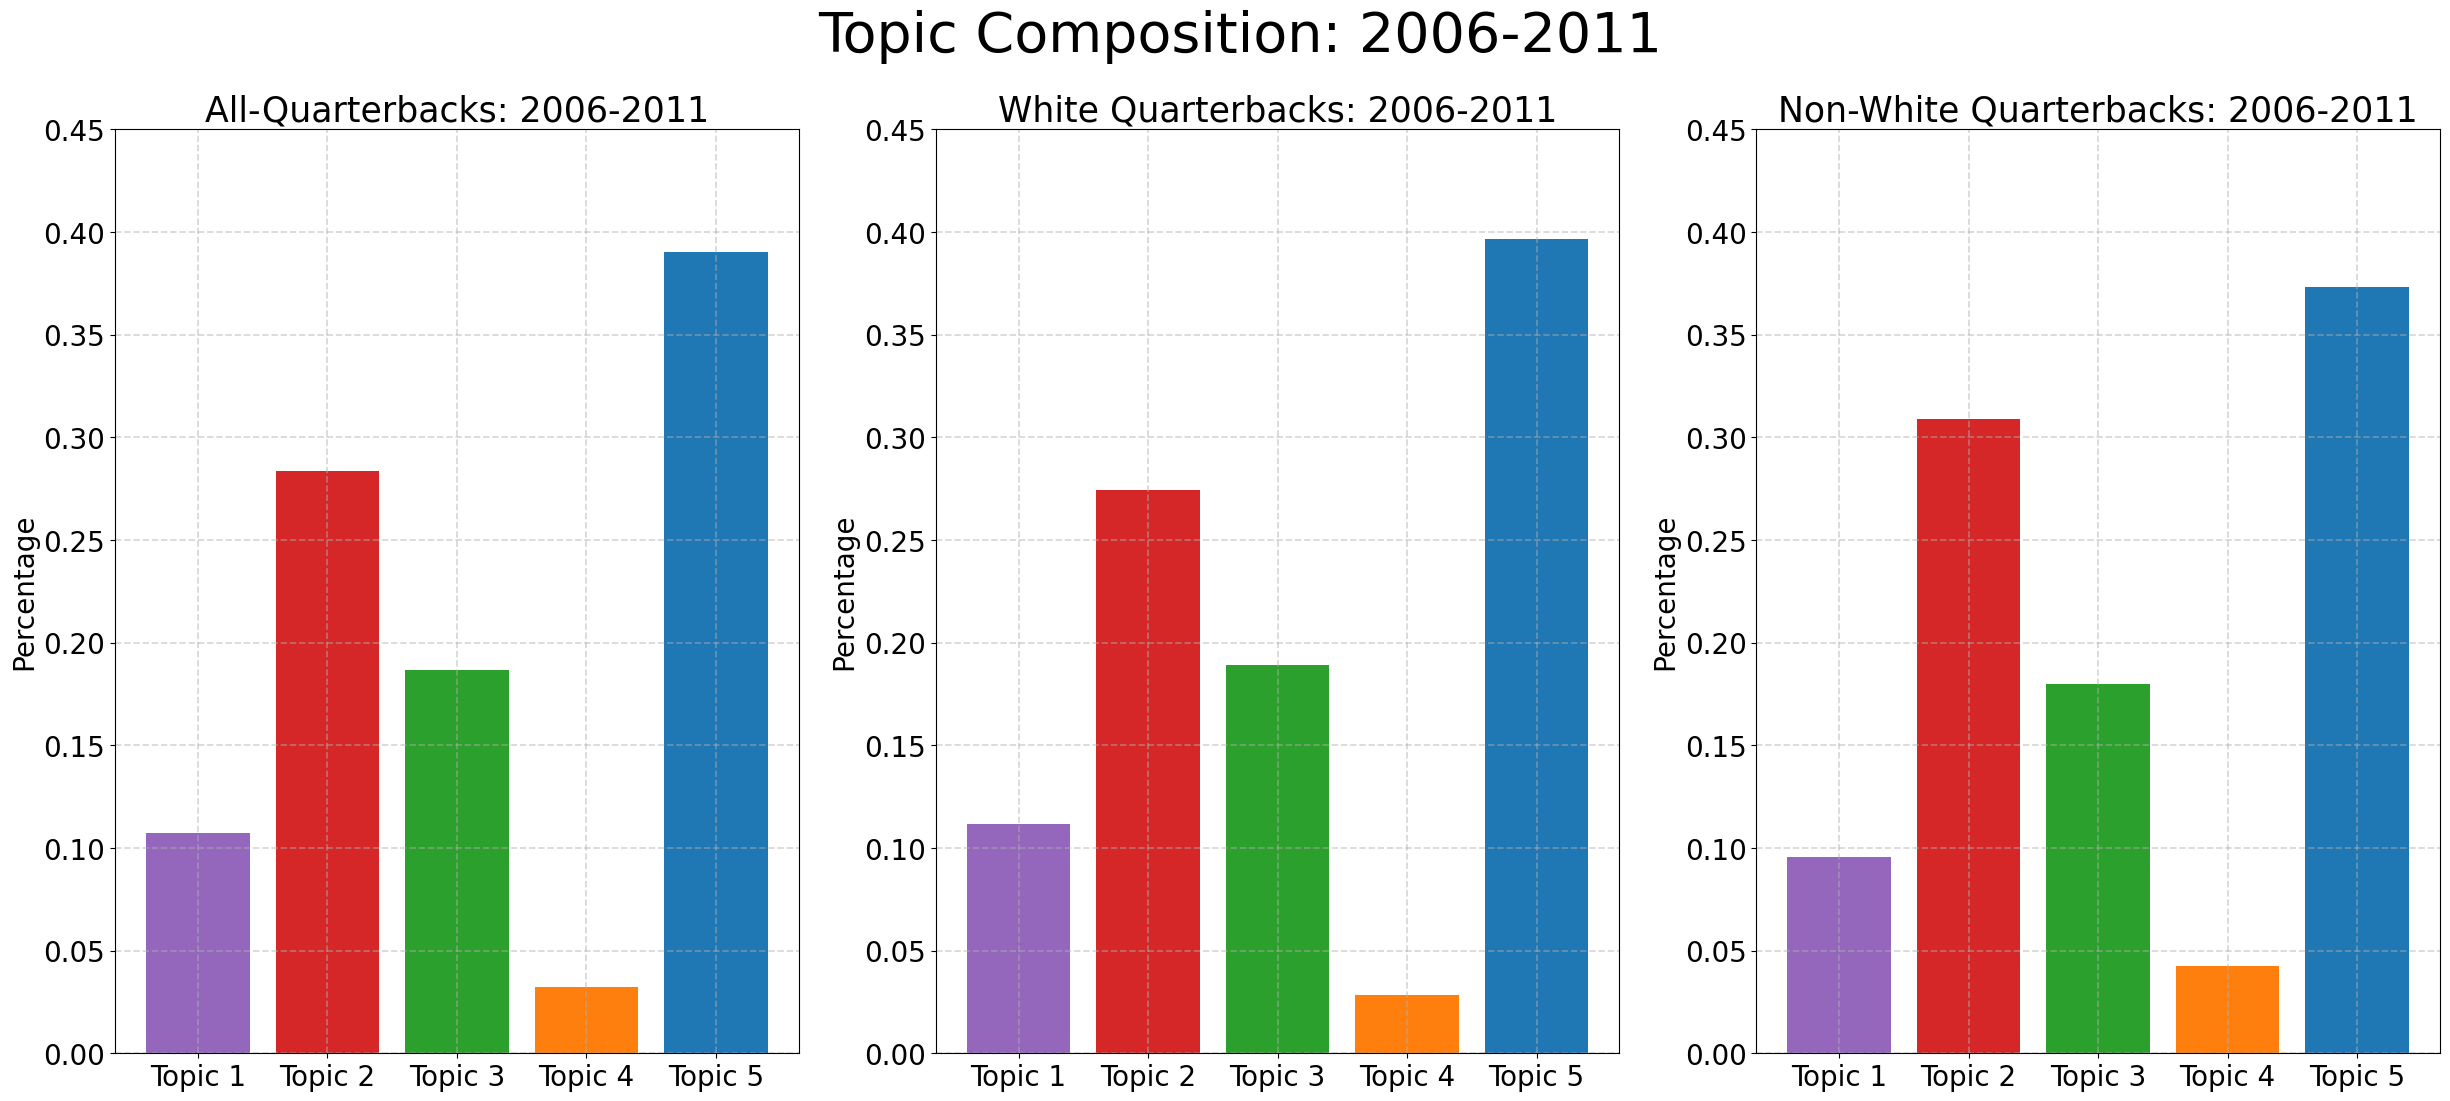

In [57]:
fig, axs = plt.subplots(1, 3, figsize=(30, 12))
plt.rcParams.update({'font.size': 20})

period = '2006-2011'
cols = ['Topic_1', 'Topic_2', 'Topic_3', 'Topic_4', 'Topic_5']
x = ['Topic 1', 'Topic 2', 'Topic 3', 'Topic 4', 'Topic 5']
colors = ['tab:purple', 'tab:red', 'tab:green',  'tab:orange', 'tab:blue']
yticks = np.arange(0, 0.46, 0.05)
grid_alpha = 0.5
linestyle = '--'
linewidth = 1.25

ax = axs[0]
y = df4[df4['Period'] == period][cols].reset_index(drop=True).loc[0]
ax.bar(x, y, color=colors)
ax.set(ylabel='Percentage', yticks=yticks)
ax.set_title(f'All-Quarterbacks: {period}', fontsize=25)
ax.grid(alpha=grid_alpha, linestyle=linestyle, linewidth=linewidth)

ax = axs[1]
y = df5[(df5['Race'] == 'White') & (df5['Period'] == period)][cols].reset_index(drop=True).loc[0]
ax.bar(x, y, color=colors)
ax.set(ylabel='Percentage', yticks=yticks)
ax.set_title(f'White Quarterbacks: {period}', fontsize=25)
ax.grid(alpha=grid_alpha, linestyle=linestyle, linewidth=linewidth)

ax = axs[2]
y = df5[(df5['Race'] == 'Non-White') & (df5['Period'] == period)][cols].reset_index(drop=True).loc[0]
ax.bar(x, y, color=colors)
ax.set(ylabel='Percentage', yticks=yticks)
ax.set_title(f'Non-White Quarterbacks: {period}', fontsize=25)
ax.grid(alpha=grid_alpha, linestyle=linestyle, linewidth=linewidth)

plt.suptitle(f'Topic Composition: {period}', fontsize=40)
plt.show()

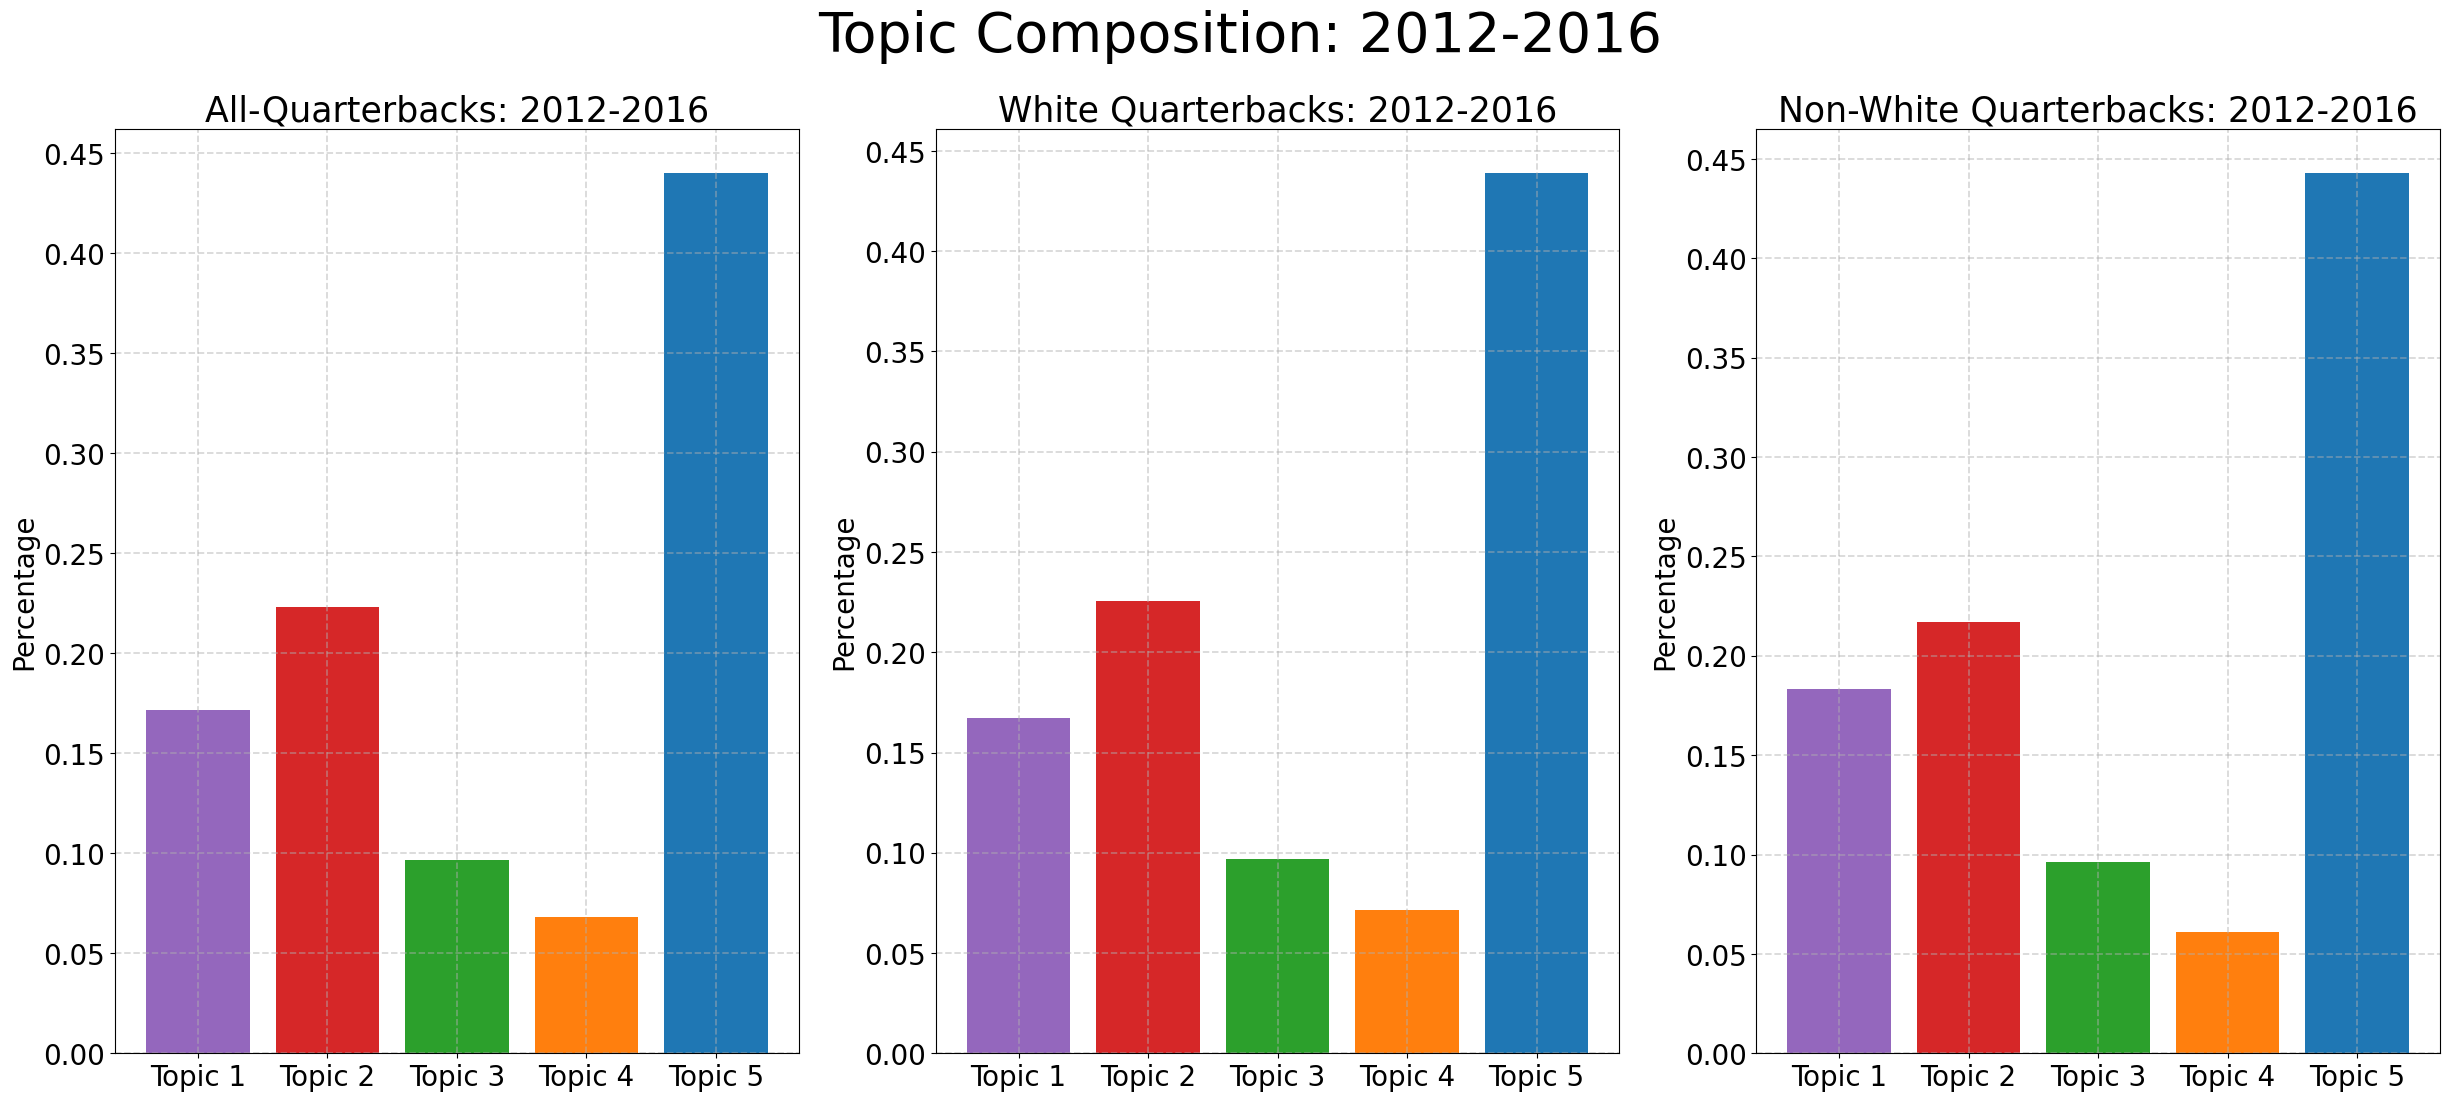

In [58]:
fig, axs = plt.subplots(1, 3, figsize=(30, 12))
plt.rcParams.update({'font.size': 20})

period = '2012-2016'
cols = ['Topic_1', 'Topic_2', 'Topic_3', 'Topic_4', 'Topic_5']
x = ['Topic 1', 'Topic 2', 'Topic 3', 'Topic 4', 'Topic 5']
colors = ['tab:purple', 'tab:red', 'tab:green',  'tab:orange', 'tab:blue']
yticks = np.arange(0, 0.46, 0.05)
grid_alpha = 0.5
linestyle = '--'
linewidth = 1.25

ax = axs[0]
y = df4[df4['Period'] == period][cols].reset_index(drop=True).loc[0]
ax.bar(x, y, color=colors)
ax.set(ylabel='Percentage', yticks=yticks)
ax.set_title(f'All-Quarterbacks: {period}', fontsize=25)
ax.grid(alpha=grid_alpha, linestyle=linestyle, linewidth=linewidth)

ax = axs[1]
y = df5[(df5['Race'] == 'White') & (df5['Period'] == period)][cols].reset_index(drop=True).loc[0]
ax.bar(x, y, color=colors)
ax.set(ylabel='Percentage', yticks=yticks)
ax.set_title(f'White Quarterbacks: {period}', fontsize=25)
ax.grid(alpha=grid_alpha, linestyle=linestyle, linewidth=linewidth)

ax = axs[2]
y = df5[(df5['Race'] == 'Non-White') & (df5['Period'] == period)][cols].reset_index(drop=True).loc[0]
ax.bar(x, y, color=colors)
ax.set(ylabel='Percentage', yticks=yticks)
ax.set_title(f'Non-White Quarterbacks: {period}', fontsize=25)
ax.grid(alpha=grid_alpha, linestyle=linestyle, linewidth=linewidth)

plt.suptitle(f'Topic Composition: {period}', fontsize=40)
plt.show()

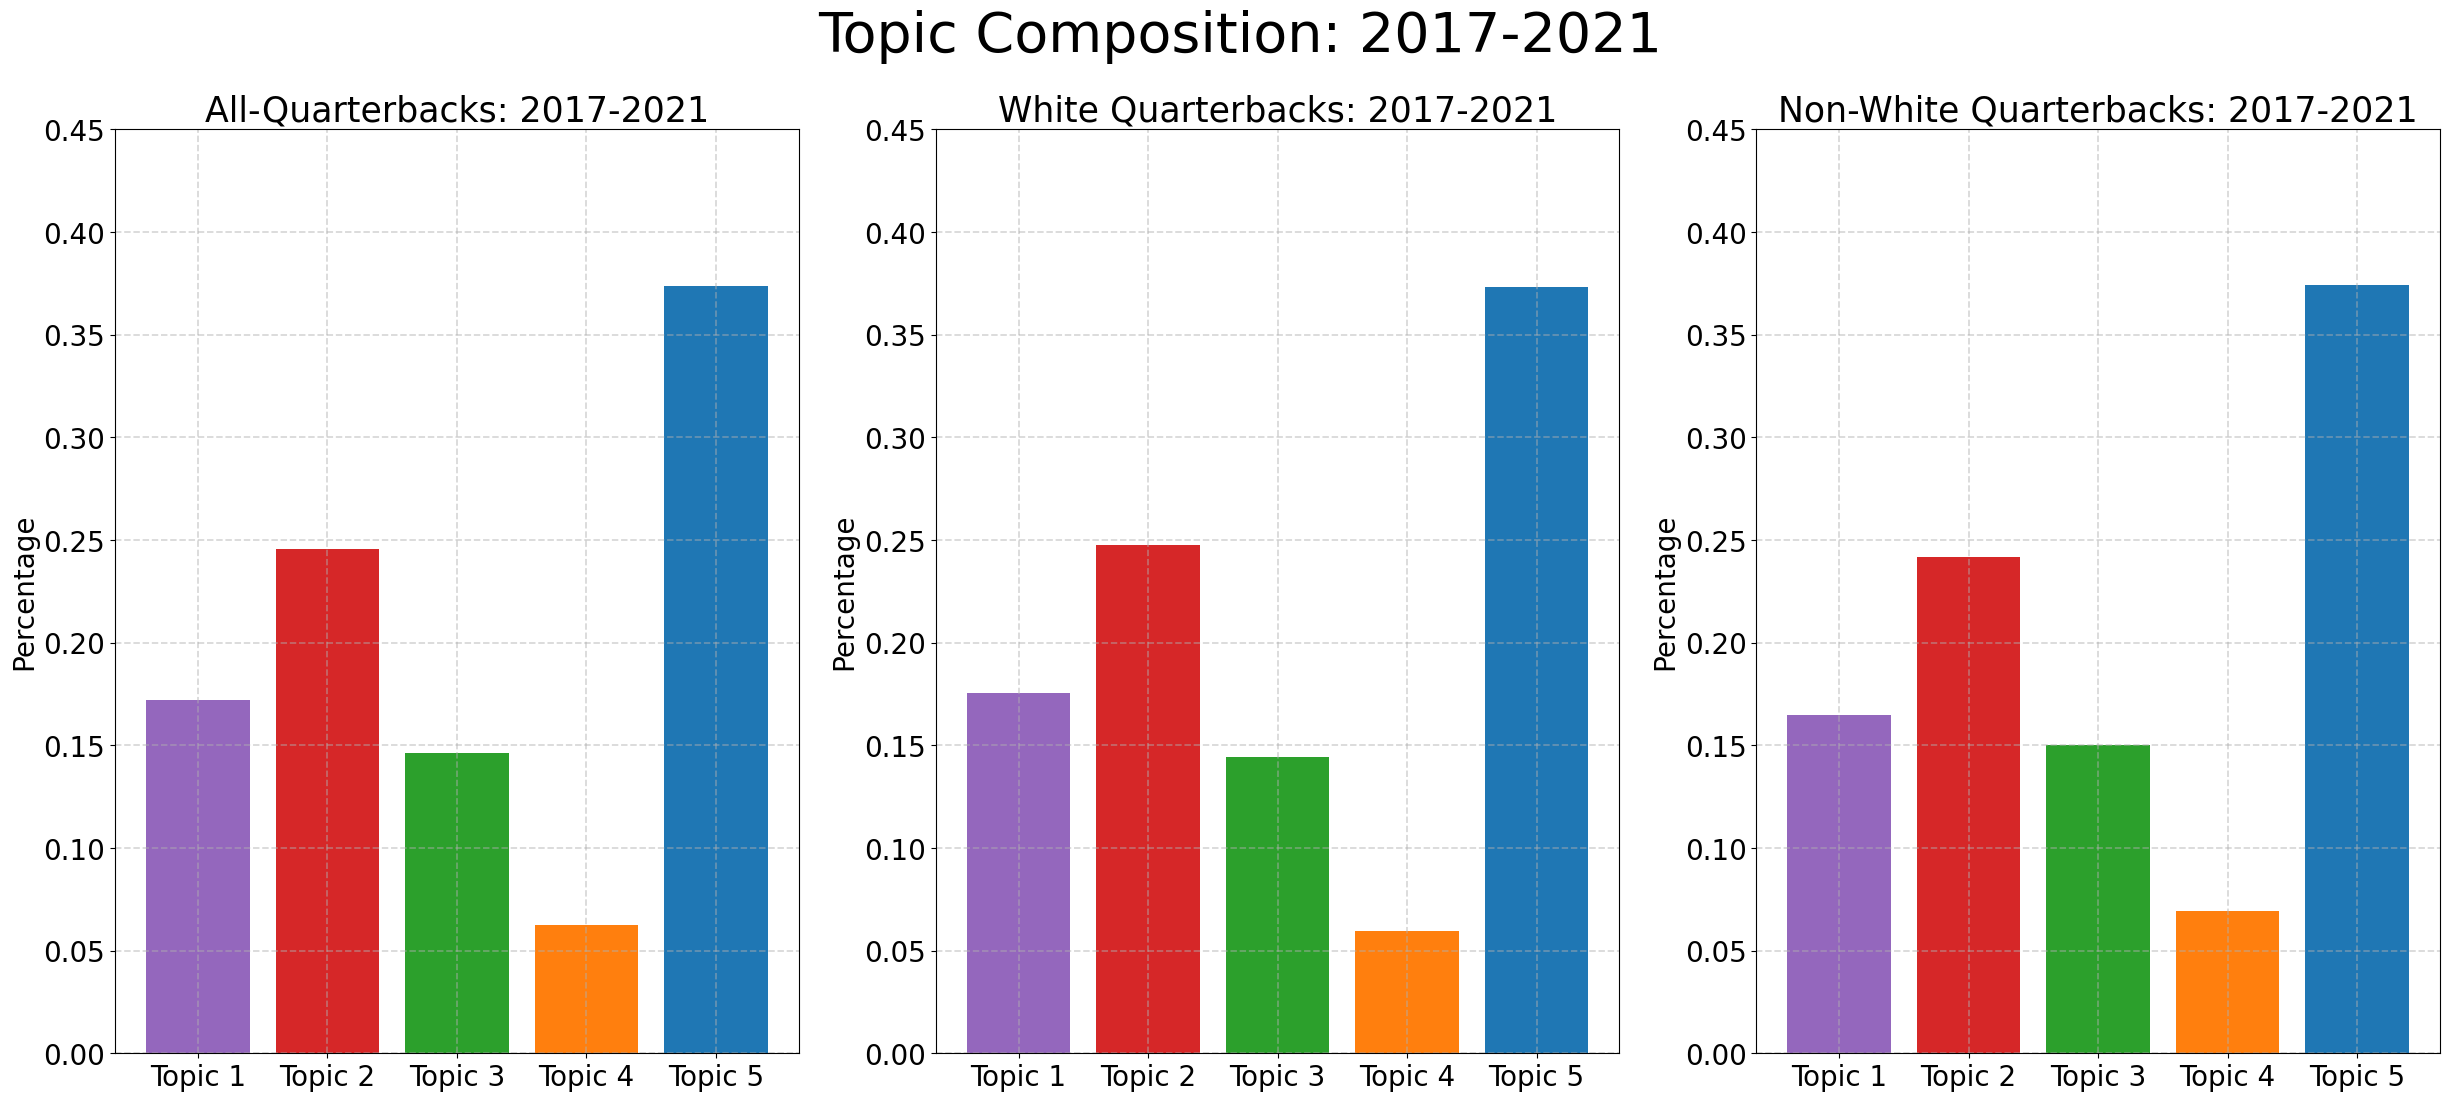

In [59]:
fig, axs = plt.subplots(1, 3, figsize=(30, 12))
plt.rcParams.update({'font.size': 20})

period = '2017-2021'
cols = ['Topic_1', 'Topic_2', 'Topic_3', 'Topic_4', 'Topic_5']
x = ['Topic 1', 'Topic 2', 'Topic 3', 'Topic 4', 'Topic 5']
colors = ['tab:purple', 'tab:red', 'tab:green',  'tab:orange', 'tab:blue']
yticks = np.arange(0, 0.46, 0.05)
grid_alpha = 0.5
linestyle = '--'
linewidth = 1.25

ax = axs[0]
y = df4[df4['Period'] == period][cols].reset_index(drop=True).loc[0]
ax.bar(x, y, color=colors)
ax.set(ylabel='Percentage', yticks=yticks)
ax.set_title(f'All-Quarterbacks: {period}', fontsize=25)
ax.grid(alpha=grid_alpha, linestyle=linestyle, linewidth=linewidth)

ax = axs[1]
y = df5[(df5['Race'] == 'White') & (df5['Period'] == period)][cols].reset_index(drop=True).loc[0]
ax.bar(x, y, color=colors)
ax.set(ylabel='Percentage', yticks=yticks)
ax.set_title(f'White Quarterbacks: {period}', fontsize=25)
ax.grid(alpha=grid_alpha, linestyle=linestyle, linewidth=linewidth)

ax = axs[2]
y = df5[(df5['Race'] == 'Non-White') & (df5['Period'] == period)][cols].reset_index(drop=True).loc[0]
ax.bar(x, y, color=colors)
ax.set(ylabel='Percentage', yticks=yticks)
ax.set_title(f'Non-White Quarterbacks: {period}', fontsize=25)
ax.grid(alpha=grid_alpha, linestyle=linestyle, linewidth=linewidth)

plt.suptitle(f'Topic Composition: {period}', fontsize=40)
plt.show()